# Proper error rate control in statistical significance testing
In this project I will discuss the important aspects of proper error control in statistical significance testing with the help of many simulated test studies and interactive visualizations. Understanding these aspects is crucial to ensure that results of statistical inference are actually meaningful and that the potential error does not get bigger than what the experimenter deems as acceptable. A non-proper treatment of error control and large amounts of resulting false positive findings has led to a reproducibility crisis in some fields of academic research as described in the now famous publication [*Why most published research is wrong*](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0020124). Less publicly visible, but similarly harmful are the same problems in the context of studies and experimentation within industry. Companies that want to leverage statistical inference to better understand their customers or improve their processes will fail to produce the expected benefits if they are not aware of the  errors they are making.

> Richard Feynman: *"The first principle is that you must not fool yourself - and you are the easiest person to fool.*" 

I will discuss the following aspects here:
1. [An introduction to statistical testing](#testing) 
    - [Motivation](#testing1)
    - [Null hypothesis significance tests](#testing2)
2. [P-values and significance levels](#pvalue)
    - [The p-value](#pvalue1)
    - [Significance levels](#pvalue2)
3. [Error types and statistical power](#error)
    - [The two types of errors](#error1)
    - [Relationship between errors](#error2)
    - [P-values as a function of power](#error3)
5. [Error correction for multiple tests](#multiple)
    - [False positive inflation by multiple tests](#multiple0)
    - [Bonferroni correction](#multiple1)
    - [Holm correction](#multiple2)
    - [False discovery rate](#multiple3)
6. [Error correction for optional stopping](#stop)
    - [P-value as a function of sample size](#stop1)
    - [False positive inflation by optional stopping](#stop2)
    - [Pocock and O'Brien-Fleming boundaries](#stop3)
    - [Alpha spending function](#stop4)
7. [Power increase and error comparison](#power)
    - [Attempts to avoid false negatives](#power1)
    - [False negative and positive comparison](#power2)
    - [Confirmatory analysis and pre-registration](#power3)
8. [Conclusion](#conclusion)

A few more notes: I tried to keep the notebook here tidy so I exiled all the Python code I used for the simulations into the script `simulate_pvalues.py` and all code I use for plotting into `err_util.py`. If you wonder how exactly something was calculated, just have a look there. I was inspired to write up this topic and to perform some simulation studies for myself to gain a better understanding after taking the very recommendable course *Improving your statistical inferences* by Daniel Lakens of TU Eindhoven on [coursera.org](https://www.coursera.org/learn/statistical-inferences?). Daniel is a great teacher and I want to acknowledge the effort he put in this course.

In [1]:
# import some libraries we'll need
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# my utility scripts for simulations and plotting
from err_util import (plot_significance_level, plot_null_hypothesis, 
plot_hypotheses_params, plot_pvalues_with_power, plot_pvalues_multiple_uncor,
plot_pvalues_multiple_bonf, plot_pvalues_multiple_holm,plot_pvalues_multiple_fdr,
plot_pvalues_over_time, plot_pvalues_optional_stopping_uncor,
plot_pvalues_optional_stopping_pocock,plot_pvalues_optional_stopping_obf)
from simulate_pvalues import (simulate_pvalues, simulate_multiple_test_pvalues,
simulate_optional_stopping_pvalues)

## Statistical significance testing <a id="testing" ></a>
### Motivation <a id="testing1" ></a>
In the real world, most processes are not perfectly deterministic. We expect certain outcomes with certain probabilities, it is normal to observe some spread in the quantities we are studying. You have good days, bad days, and anything in between. That also means that if we are observing differences or correlations between quantities of interest, we need to find out if the difference or correlation is caused by an actual underlying effect, or if it is just due to random fluctuations. We want to know if the observed effect is **significant**. 

An example: You make changes on your e-commerce website which intend to make it easier for your customers to put articles in their shopping cart and check out. You do, in fact, observe a slight increase in conversion rate. But is that really due to the changes you made, or could it be just due to random chance? Is the effect you observe statistically significant?

If we consider something as significant, it basically means that we would consider the observation as very surprising or unlikely if there was no real underlying effect. To put these idea in a mathematical framework, statistical hypotheses tests are used. This is also referred to as confirmatory analysis, because we are testing hypotheses which were probably generated in an exploratory part of the research process. I'll elaborate a bit on why it is good to keep these parts separated later on.

### Null hypothesis significance tests <a id="testing2" ></a>
The most common kind of test approach is a null hypothesis significance test. The null hypothesis reflects the assumption that there is no real effect (i.e. no difference, no correlation, or whatever we are interested in). Opposed is the alternative hypothesis, stating that there is an effect different from zero (can also be specified as smaller or larger). We know how observations should be distributed if the null was true, and so, we can see how surprising the observed data would be if the null was true. If the data would be very surprising  under the null, we reject the null in favor of the alternative. 

How surprising does it have to be? I'll discuss the border line for significance, called significance levels, in the next section. But we'll have to calculate a test statistic from the data first, which could then either cross this border or not. Depending on what we want to test for, how many groups we consider, and what assumptions we make about the distribution of the data, there are a lot of parametric and non-parametric tests we can chose from. I want to keep the discussion as general as possible so I will not go into detail here. Nonetheless, one has to be aware that it is important to chose an appropriate test statistic. If assumptions of the test are violated, the results can be very wrong.

Besides null hypothesis significance tests there are also equivalence tests. Testing against the null hypothesis will just tell you if there is an effect different from zero. This effect may still be smaller than what you care about, than what you would consider as "equivalent". These tests check not only if there is an effect at all, but also if it is outside of the equivalence range you define. Since not everyone knows what effect sizes to expect and null hypothesis significance tests are much more common, I will focus on the latter in this discussion.

## P-values and significance levels <a id="pvalue" ></a>

Lets first talk about what we actually mean by **probabilities** in this context. Null hypothesis significance tests are part of the framework of frequentist statistics. As the name already implies, probabilities assigned to observed data are considered as longterm frequencies of the data. If we would repeat our sampling process an infinite amount of times, the frequency with which the observed data would appear, would correspond to its probability under the given hypothesis. It is important to note that we consider the probability of data under the assumption of a hypothesis and **not** the probability of any hypothesis being true or false. This is a different idea of probability as e.g. in Bayesian statistics, where we interpret probability as a degree of believe in a hypothesis.

### The p-value <a id="pvalue1" ></a>
If we want to know how surprising the observed data is under the null hypothesis, we can use the test statistic which was calculated from the data, compare it to the distribution under the null, and calculate the probability of observing a value as extreme as or more extreme than the observed value. This probability is called the **p-value**. It is the probability of getting the observed data or even more extreme data, given that the null hypothesis is true. It **is not** the probability of the theory or the hypothesis being true or false. I'm stressing this here because this often confused in practice.

An example: We want to know if the mean of a sample is significantly different form the mean of a population (e.g. sales to a specific group of customers compared to all the customers). If the sample was from the population, the differences in sample mean and population mean should be normally distributed around zero. Due to sampling error, the difference will usually not be exactly zero, but we expect it to not be very large either.

Let's look at the figure below. We can see how observations would be distributed under the null hypothesis, $H_0$. We can also see one observation and a red shaded area under the distribution. This (integrated) shaded area corresponds to the probability of observing data as extreme or more extreme than this observation. This probability is the p-value.

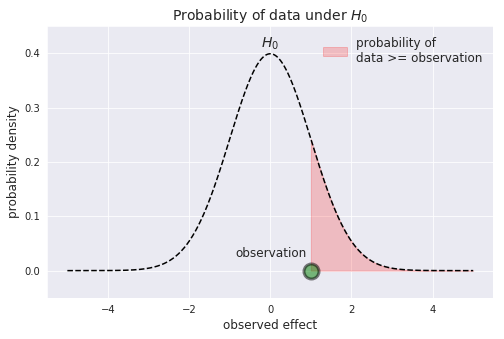

In [2]:
plot_null_hypothesis()

### Significance levels <a id="pvalue2" ></a>
We can see in the figure above that the more extreme the data wold be under the null, the smaller its probability (its p-value). We can now freely pick a boundary beyond which we consider the data too unlikely to appear under the null. This boundary is called the **significance level, $\alpha$**. It is very often chosen to be 0.05, but in principle one can chose any value that one considers reasonable for the given situation. If the p-value is smaller than $\alpha$, we will **reject** the null hypothesis in favor of the alternative hypothesis. If the p-value is larger than $\alpha$, we will **fail to reject** the null hypothesis.

You can find this concept visualized in the figure below. Given a significance level of $\alpha$ = 0.05, we will retain $H_0$ if the observed data falls within the 95% most likely values (white-shaded area). We will reject $H_0$ if the observed data falls within the 5% least likely values (red-shaded area). In this case we consider extreme values both on the low and the high end but one can also conduct one-sided test to either side.

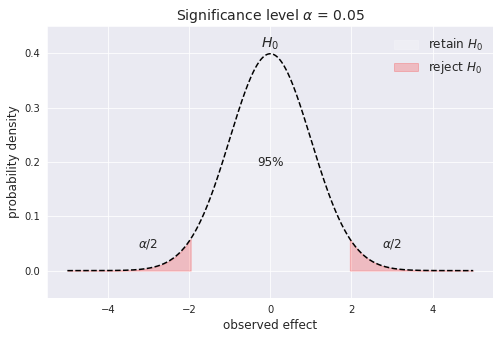

In [3]:
plot_significance_level()

Again, the p-value **is not** the probability of the theory or the hypothesis being true or false. Probabilities in a frequentist context are the longterm frequency of the data, under an assumed hypothesis. P-values do not tell you truth about something; in every explicit example, every individual test the null is either true or not. There either is an effect or not. P-values should only be used to separate signal from noise and to guide behavior in the long run to ensure a proper control of the error rates, which is what I will discuss in the next section.

## Error types and statistical power <a id="error" ></a>

### The two types of errors <a id="error1" ></a>
Let's think about what can happen in a null hypothesis significance test. Either the null or the alternative hypothesis is true. If the null is true and we do not find a statistically significant effect we got a **true negative**. If the alternative hypothesis is true, we find statistically significant effect and reject $H_0$, we got a **true positive**. But what if we were wrong? We can find a significant effect even though there actually is no effect. That is a **false positive** or **type 1 error**. We can also fail to detect a significant effect even though there is one. That is a **false negative** or **type 2 error**.

As discussed above, by defining $\alpha$, we define how unlikely data has to be under $H_0$ for us to reject $H_0$. This way we also defined the false positive rate. If $\alpha$ = 0.05 that means that in maximally 5% of the cases, the data that makes us reject $H_0$ could actually have occurred under $H_0$ and we rejected it incorrectly. At $\alpha$ = 0.05, at most 1 out of 20 tests could, hence, be a false positive. We see an effect where there actually is none.

If the data is not  surprising under the null, it does not necessarily mean that there is no true effect. Maybe there is none, but maybe we have just failed to detect it and gotten a false negative. The false negative error rate is usually denoted as $\beta$. The quantity 1-$\beta$ is called **power** and it represents the probability of detecting an effect when it is actually there, i.e. obtaining a true positive. The higher the power, the more likely it is to detect a real effect and, consequently, the less likely to obtain a false negative.

### Relationship between errors <a id="error2" ></a>
The power itself depends on the chosen significance level, $\alpha$, the effect size, $d$, and the sample size, $n$. I have visualized this relationship in the interactive figure below. The distributions under the null, $H_0$, and the alternative, $H_a$, hypotheses are displayed. The centers of the distributions are separated by the effect size, $d$. The shaded areas represent the probabilities of true negatives (white), false positives (red), false negatives (blue), and true positives or power (green). You can change the effect size, sample size, and significance level with the sliders below. Please play around a bit.

Column
    [0] Column(align='center')
        [0] Markdown(str)
        [1] Column
            [0] DiscreteSlider(name='d', options=[0.0, 0.1, 0.2, ...], value=0.5)
            [1] DiscreteSlider(formatter='%d', name='n', options=[5, 6, 7, 8, 9, ...], value=30)
            [2] DiscreteSlider(name='alpha', options=[0.001, 0.002, ...], value=0.05)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00006')
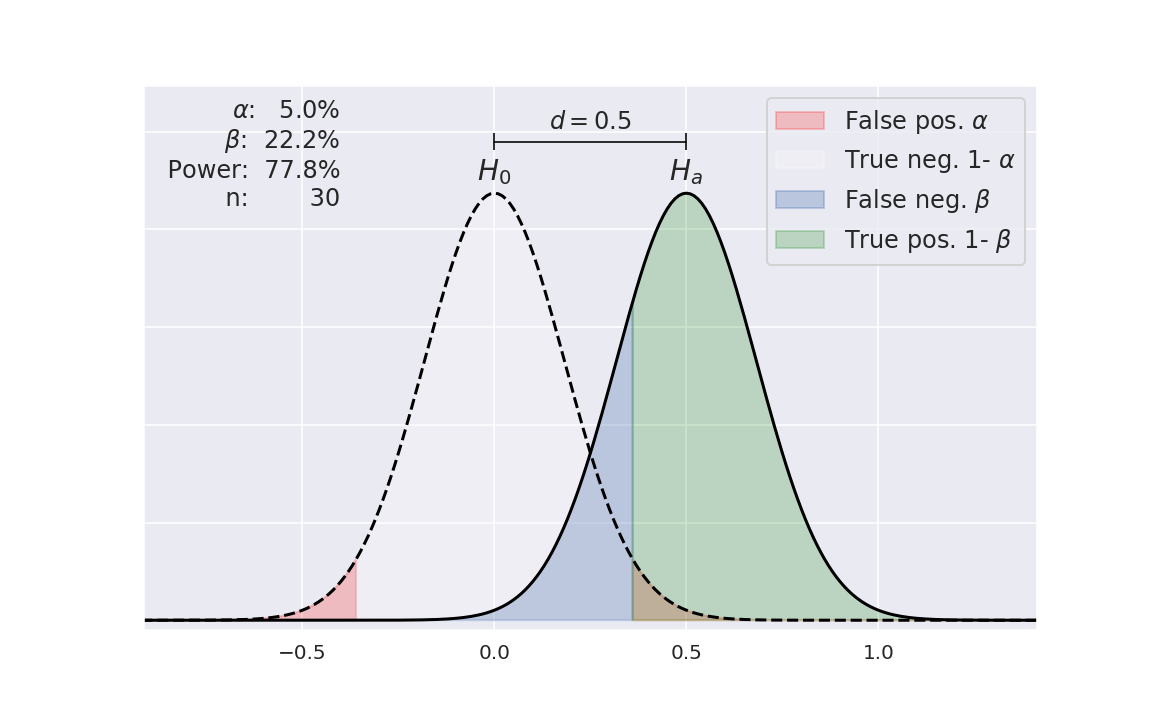

In [4]:
plot_hypotheses_params()

The less these two distributions overlap, the smaller the errors. We can chose the false positive rate $\alpha$ freely, but the smaller we set it, the more we push the $H_0$-rejection-boundary into the distribution of $H_a$, thereby, reducing power. The larger the sample size, the smaller the spread of the distributions (e.g. the standard error of the mean scales with $\sqrt{n}^{-1}$), increasing the power. The smaller the effect size, the closer the distributions come together, decreasing power.

If we don't want to compromise on $\alpha$ and we cannot influence the actual $d$, we have to chose the smallest $d$ that seems relevant to us and chose the sample size accordingly to achieve the desired power. Small effects need larger samples. Is there a real effect or not? If the p-value is over 0.05 you cannot answer this question. Maybe there is none, maybe your study was just under-powered.

If you design your studies with power in mind, you will not make more errors in the long run than the rates you control for. It will, however, not tell you if an individual finding is true or false - this is one of the reasons why replication studies are so important in experimentation. Errors will occur by design. We cannot avoid that, but if we replicate, we will at least be able to detect them in hindsight. If you're already tired of me mentioning over and over again how frequentist statistics is all about longterm, infinite-repetition-kind-of concepts, you should probably garb a Bayesian stats book.

### P-values as a function of power <a id="error3" ><a/>
If we still want to stick to frequentist hypothesis testing and the idea of probabilities as long term frequencies, we will probably wonder what distribution of p-values to expect in the long run, given a certain effect.
    
I took a simulation approach in this section. That's actually always a great idea if possible; simulate the process you are interested in, and compare your observations with the simulation's output. In this case I simulated 10000 Student's t-tests on samples of size 100, each sampled from normal distributions separated by $d$. I repeated this simulation for different values for $d$, each corresponding to powers in the range of 0 to 1 in steps of 0.1, at $\alpha$ = 0.05.

We can see a histogram of the p-values values coming out of the 10000 simulated t-tests below. For a power of 0 corresponding to $d$ = 0 (no difference, $H_0$ is true), we can see that the p-values are uniformly distributed between 0 and 1. We can get any p-value with equal probability. Now, this makes a lot of sense in relation to $\alpha$, the significance level or false positive rate. If we choose $\alpha$ = 0.05, we would declare every p-value below 0.05 (shaded in red) as statistically significant and reject the null. As we can see here, where $H_0$ is true, we would make a mistake 5% of the time because under $H_0$ being true, 5% of the simulated p-values are lower or equal to 0.05.

Please move the slider in the figure below to increase the power and see how the distribution of p-values changes.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(name='power', options=[0.0, 0.1, 0.2, ...], value=0.0)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00048')
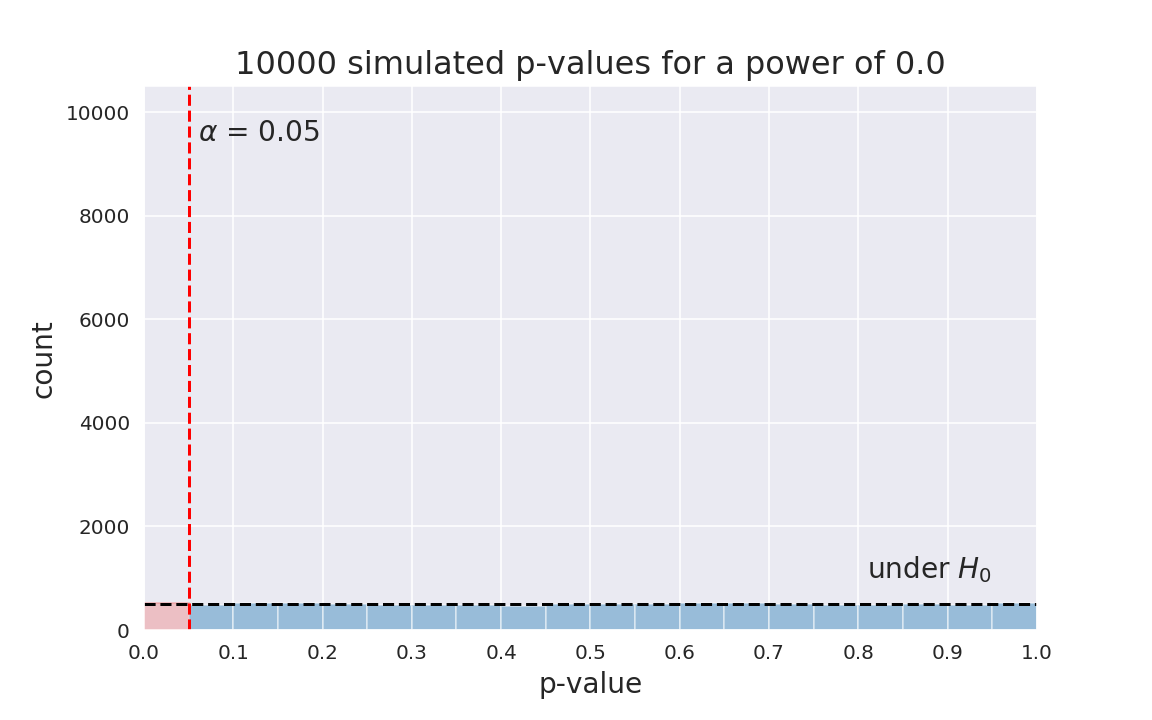

In [5]:
plot_pvalues_with_power()

If we increase the power, we introduce a real effect, which means now $H_0$ is false. In this case we would like to get a significant result so that we can reject $H_0$. At low powers, however, there are still plenty of p-values above the significance threshold. The higher the power, the more p-values will fall under $\alpha$. E.g. at a power of 0.5, ca. 5000 out of 10000 simulated p-values are lower than $\alpha$. This is the intuition behind the definition of power: the probability of detecting an effect if there actually is an effect. If you want to be sure to not miss the smallest effect you care about, make sure you have sufficient power by having a large enough sample size.

The higher the power, the more very small p-values can be expected if $H_a$ was true. That also means that when you know that you have a very high power, not all p-values below $\alpha$ should be seen as an evidence for $H_a$. At very high power (e.g. 0.99), under $H_a$, a p-value of e.g. 0.001 would be much more likely than 0.049. You may then conclude that p=0.049 would be unlikely under $H_0$, but it would be even more unlikely under $H_a$. This is also known as [Lindley's paradox](https://en.wikipedia.org/wiki/Lindley's_paradox).

## Error correction for multiple tests <a id="multiple" ></a>

### False positive inflation <a id="multiple0" ></a>
As I have discussed above, we will set the false positive rate by setting the significance level $\alpha$. If we chose to set $\alpha$=0.05, we are willing to accept that one out of 20 findings might be a false positive. This naturally implies that, the more tests we conduct, the higher the chance that false positives will be among them. The overall significance level $\alpha$ would change to $\alpha = 1 - (1-\alpha_i)^n$, where $\alpha_i$ is the significance level for the individual tests and $n$ is the number of tests. That means if we conduct multiple comparisons within one study and we want to keep the studies' overall error rate at the desired level, we will have to control the family-wise error rate of all tests involved. We will have to not just apply the overall $\alpha$ to every test individually, but adjust every individual test's $\alpha_i$ so that the overall $\alpha$ is controlled. 

An example: Imagine you're conducting a multi-factor ANOVA test in which you want to see which influence several factors could have on an observed quantity, both alone and in interaction with each other. You may, e.g. be observing people's life expectancy and testing if there is a significant correlation with gender (only male or female here for simplicity), smoking (yes or no), and marriage status (married or not), or with the 2-way interaction terms (e.g male and smoking). In this setup with 3 factors, considering 2-way interactions and 1-way main effects, you'd already be conducting 6 tests at once and you'd get 6 p-values. If you'd keep $\alpha$=0.05 for each of these p-values, the family-wise error rate would be much higher than 0.05.

I simulated this scenario (ANOVA with 2-way interactions and 1-way main effects) with 3 to 7 factors resulting in 6 to 28 tests per study. I sampled the dependent variable randomly from a normal distribution, which means there is no real effect. $H_0$ is true for all these simulated examples. As you can see in the figure below, much more than 5% of the 10000 simulated studies will show some significant results. The uncorrected multiple comparisons have inflated the family-wise error rate. Please play around with the slider to increase the number of tests and see how the error inflates even more.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='ntests', options=[6, 10, 15, 21, 28], value=6)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00070')
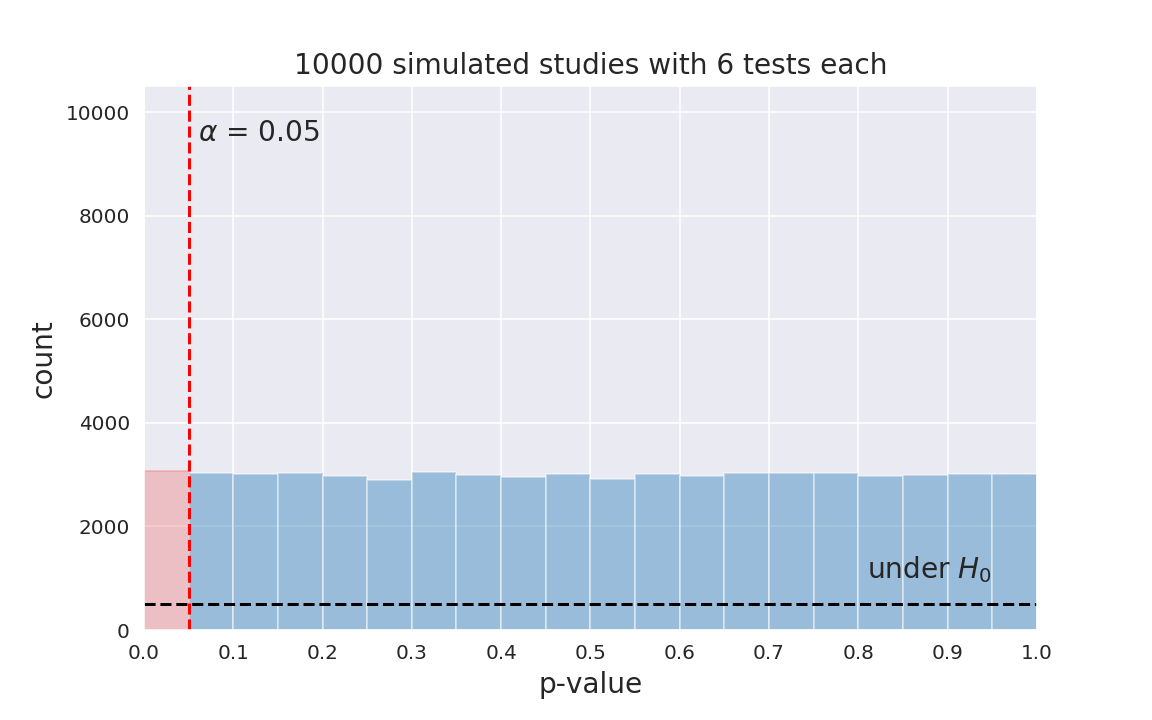

In [6]:
plot_pvalues_multiple_uncor()

### Bonferroni correction <a id="multiple1" ></a>
Luckily, there are a couple of methods with which the false positive rate can be controlled when doing multiple comparisons. The most straight forward method is probably the Bonferroni correction (which should maybe rather be attributed to [Dunn](https://en.wikipedia.org/wiki/Olive_Jean_Dunn)). I couldn't find an original paper, but the idea is simple: the significance level, $\alpha$, is just divided by the number of tests. Alternative, each test's p-value can be multiplied by the number of tests, keeping the original $\alpha$. P-values larger than one do not make any sense, so the adjusted p-values will be clipped off at a maximum of one.

We can see in the figure below how the Bonferroni correction strictly controls the family-wise error rate for any number of tests. The large bin at 1.0 results from adjusted p-values being larger than 1.0 clipped off at 1.0.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='ntests', options=[6, 10, 15, 21, 28], value=6)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00092')
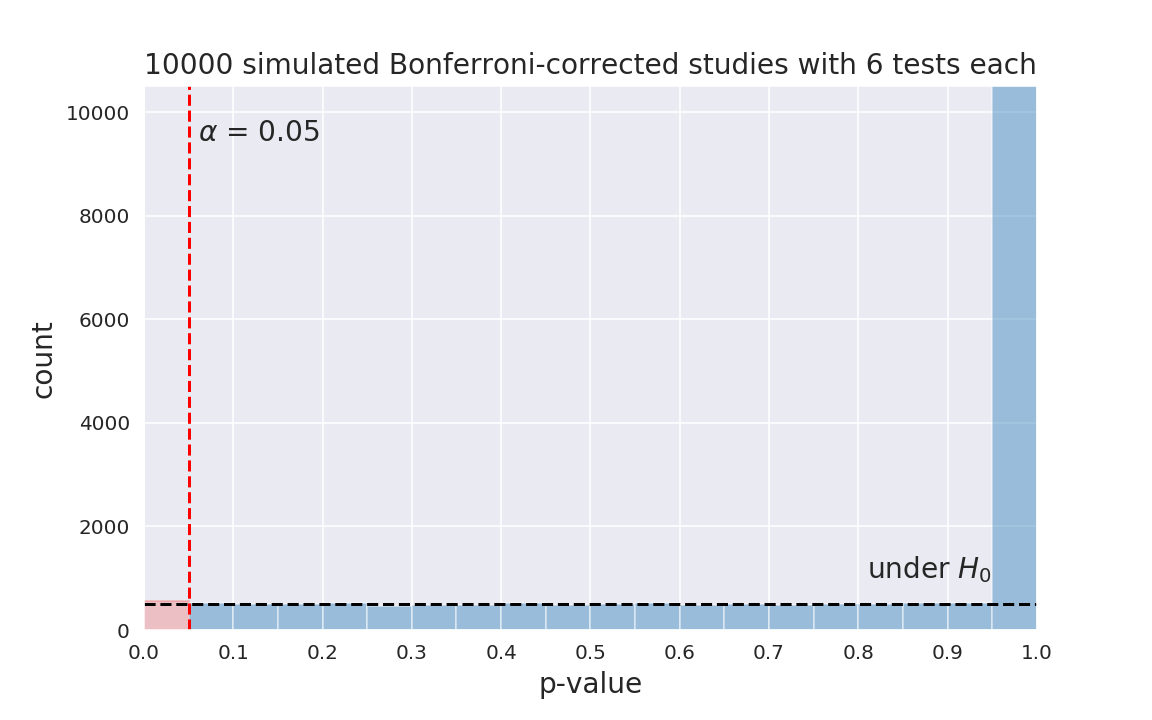

In [7]:
plot_pvalues_multiple_bonf()

The Bonferroni correction, however, assumes statistical independence between all tests, which is usually not the case in studies where many tested factor could be related to each other. In that case, the Bonferroni correction is too conservative in the sense that it may reduces the individual tests' $\alpha_i$ more than necessary. This can be a problem because it reduces the power of the tests, makes them less likely to detect an effect if there is one, thereby, increasing the chance of false negatives.

### Holm correction <a id="multiple2" ></a>
There is another option, which addresses this problem. Actually, there are plenty of other options (find an overview [here](https://en.wikipedia.org/wiki/Family-wise_error_rate#Controlling_procedures)), but I'll only discuss the most common ones to not explode the scope of this work. The next one I want to talk about is the [Holm correction](https://www.jstor.org/stable/4615733?seq=1#page_scan_tab_contents), which is a bit like a step-down sequential Bonferroni correction. The p-values are first reverse-ranked and then each $\alpha_i$ is divided by the corresponding p-value's reverse rank (i.e. the $\alpha_i$ corresponding to the smallest p-value is divided by the highest rank). Once we fail to reject a $H_i$, we can stop testing because the following ones cannot be significant either. We can, of course, also adjust the p-values instead of the $\alpha_i$ by multiplying them with their reverse rank or setting them  equal the cumulative maximum of adjusted p-values. That means if $p_1$ (the smallest $p_i$) multiplied with its rank is already larger than $p_2$ multiplied with its rank, the adjusted value for $p_2$ will be equal to $p_1$ multiplied with its rank. You can find the equation [here](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method#Adjusted_p-values) if the verbal explanation is a little confusing.

The advantage of Holm over Bonferroni is that it is uniformly more powerful. It doesn't lower each individual test's $\alpha_i$ as much and hence, does not reduce its power as much. It does not inflate the false negative rate that much while still controlling the false positive rate quite well. In the figure below you can see the distribution of Holm-corrected p-values from the same simulated studies as before.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='ntests', options=[6, 10, 15, 21, 28], value=6)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00114')
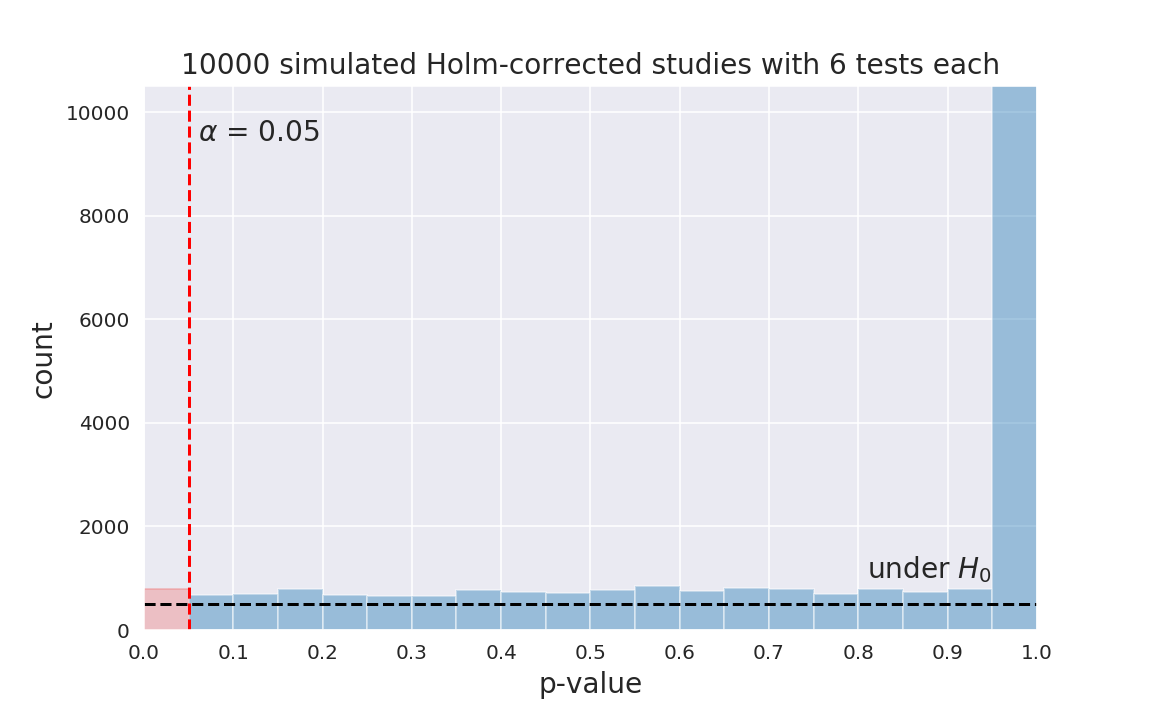

In [8]:
plot_pvalues_multiple_holm()

### False discovery rate <a id="multiple3" ></a>
The Bonferroni and Holm correction methods aim for controlling the **family-wise error rate**.
That means making **at least one** false positive per study. It  can be  considered as an error rate  per experiment or per study. Another approach for controlling false positives is provided by controlling the **false discovery rate**. This aims at controlling the overall proportion of discoveries that are false directly, and not at controlling the rate of experiments which may be flawed with at least one false positive.

The probably most common procedure of this kind was proposed by [Benjamini and Hochberg](https://www.jstor.org/stable/2346101?seq=1#page_scan_tab_contents). It works a bit like in the Holm method but bottom-up. The p-values are sorted and ranked. Then starting from the highest p-value, the adjusted p-value is the lower option of either, $p_i * n / i$, meaning the $i^{th}$ p-value, $p_i$, multiplied by the number of tests, $n$, divided by its rank, $i$, or the cumulative minimum of the previously adjusted p-values. That means if one of the previously adjusted p-values was already lower than the adjusted $p_i$, then adjust $p_i$ to that lower value. This [video](https://www.youtube.com/watch?v=K8LQSvtjcEo) walks you through the idea step-by-step in case this short summary sounds a little opaque.

The figure below shows the distribution of p-values adjusted with the false discovery rate (Benjamini-Hochberg) method for the same 10000 simulated studies as before in  which $H_0$ is true. Please move the slider to change the number of tests per study and see how the amount of false positives (p-values below 0.05) changes.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='ntests', options=[6, 10, 15, 21, 28], value=6)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00136')
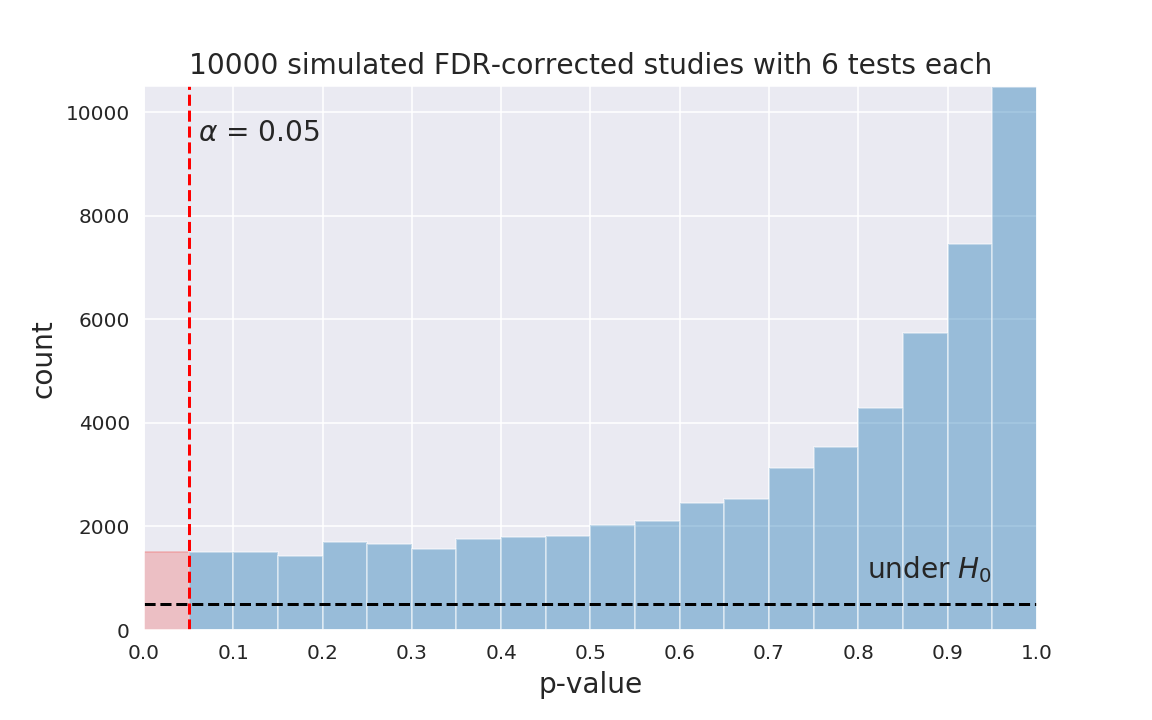

In [9]:
plot_pvalues_multiple_fdr()

Compared to the family-wise error control methods, the false discovery rate provides larger power but often higher false positive rates. Which method you want to chose really depends on the application. In my personal experience, both academics and people in industry are not as diligent in replicating experiments as the maybe should be and, hence, I like the idea of a more stringent false positive control. But in many high-throughput experiments where many variables to test can be extracted from small-sized samples (e.g. genetic sequencing), power can already be intrinsically low. It may then be a good idea to use the false discovery rate as a higher-powered correction method rather than the family-wise error methods.

## Error correction for optional stopping <a id="stop" ></a>

As we now know, we need sufficiently large samples if we want to have a high power. But collecting more data points is often very time and money consuming. During the collection period we may wonder if the information we need is already in the data that was collected up till now. In situations like medical trials, coming to a true positive result earlier could even save lives. We could peek and do a test already, maybe the p-value will be lower than $\alpha$ already. But hey, that's dangerous. We would basically be performing multiple tests again, inflating the false positive rate. The different methods we can use to do this correctly are generally summarized under the term **sequential analysis**. I will discuss the basic ideas and most commonly used correction methods here, but I also want to point you to a [nice introductory paper](http://datacolada.org/wp-content/uploads/2015/12/5367-Lakens-EJSP-2014-Performing-high-power.pdf) by Daniel Lakens with more details, references, and some real-world examples.

### P-value as a function of sample size <a id="stop1" ></a>
Let's remember from before that if there is no effect, $H_0$ is true, then p-values are uniformly distributed. So if we perform a test after every data point collected, the p-value should be below 0.05 about 5% of the time. We will inevitably find a p-value below $\alpha$ at some point. The more frequent we look, the higher the chance that a least one of the looks will yield a significant p-value and, if we then stop data collection, we will produce a false positive.

I set up a simulation where samples are randomly drawn from normal distributions and a Student's t-test is performed on them. You can test this in the figure below where you can change the sample size, $n$, and effect size, $d$. Every time you change the parameters, the distribution will be re-simulated and plotted. For $d$=0 there is no effect, $H_0$ is true. There will still be around 5% cases in which the p-value drops below 0.05. Change $n$ to trigger re-plotting a couple of times and have a look yourself. Now you can understand why "peeking" can be dangerous without correction. You might accidentally peek while the p-value has randomly dropped below $\alpha$.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='n', options=[20, 30, 40, 50, ...], value=200)
            [1] DiscreteSlider(name='d', options=[0.0, 0.1, 0.2, ...], value=0.0)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00158')
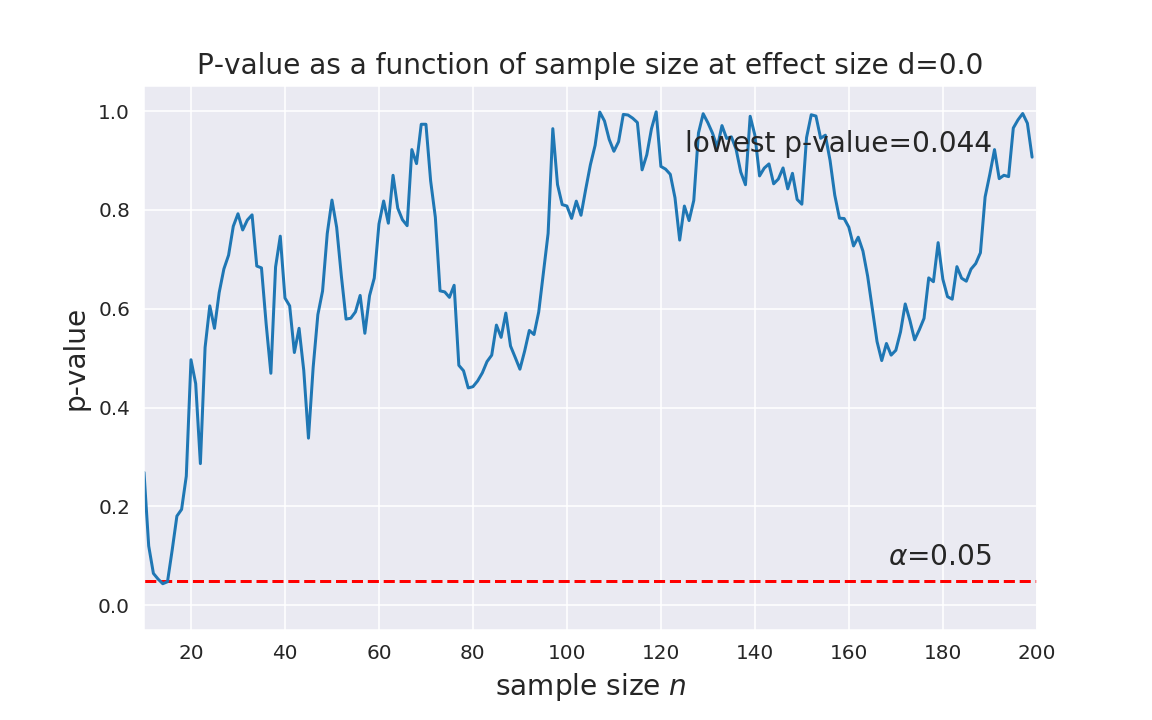

In [10]:
plot_pvalues_over_time()

If you increase $d$ above zero, there is a real effect, $H_0$ is false. If we can detect the effect or not depends on the power. As discussed before, power depends on $\alpha$, $d$, and $n$. At $d$=0.3 and a sample size $n$=90, the power is a bit higher than 50% which means the p-value should drop below $\alpha$ in a bit more than half the cases.

If you increase the sample size and keep the effect size low, you can observe that sometimes the p-value drops below $\alpha$ but then rises above $\alpha$ until it finally drops again. This shows that even if there is a real effect, if we don't know the exact effect size and can calculate the required power in advance, it can be hard to know when exactly what sample size is really sufficient.

### False positive inflation by optional stopping <a id="stop2" ></a>
Now, is there anything we can do about optional stopping while the data collection is still running without completely messing up the false positive rate? Well, I guess if there wasn't, I wouldn't be writing this paragraph. But before we discuss methods to correct $\alpha$, let's try to understand how it inflates when **optional stopping** is performed. Optional stopping means that we will already perform interim tests (looks) before the entire final sample size is collected. If one of these interim tests yields a significant p-value, we conclude a significant result already and stop data collection. It is a bit more complicated than for the case of independent multiple tests because the probabilities are conditional now: The probability of finding a significant result at the second look also depends on the probability of not finding a significant result at the first look. 

I simulated (this time 100000 times) the situation of performing Student's t-tests with optional stopping on samples of size 100 which are randomly drawn from the same normal distribution, which means there is no real effect, $H_0$ is true. For each simulated study, 2, 4, or 5 looks are performed. If the p-value is below $\alpha$ at one of the looks, this p-value is considered for this particular simulation. If not, the p-value of the final look is  considered.

You can see the results in the figure below. I have  chosen smaller bins now so that the structure of the p-value distribution is visible more clearly. You can see that if optional stopping is performed, values that should have been above the significance level get pulled below it and contribute to the false positive rate. The more looks per study are allowed, the more the false positive rate gets inflated.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='nlook', options=[2, 4, 5], value=2)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00189')
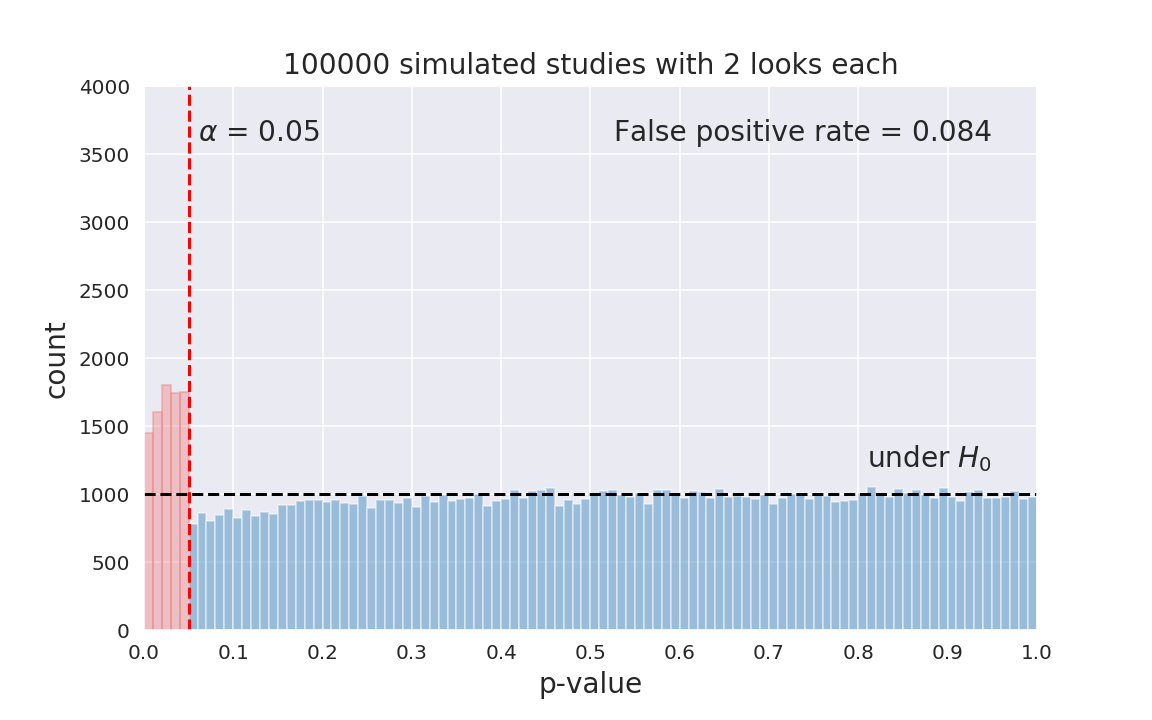

In [11]:
plot_pvalues_optional_stopping_uncor()

### Pocock and O'Brien-Fleming boundaries <a id="stop3" ></a>
To correct the significance levels or p-values for the individual looks, some boundary methods were proposed. The idea is that, under $H_0$, for $n$ interim tests/looks, the conditional probabilities of obtaining a significant p-value at each $n^{th}$ look, considering the probabilities of not obtaining a significant p-value at the previous looks, all have to add up to the overall desired significance level, $\alpha$. That  basically means that the $\alpha$ is being spent over the course of the interim tests in a way that the overall $\alpha$ is controlled to the desired level.

The [Pocock boundary](https://academic.oup.com/biomet/article-abstract/64/2/191/384776?redirectedFrom=fulltext) correction method adjust the $\alpha_i$ for each individual interim test to the same value (or alternatively multiplies each $p_i$ with $\alpha/\alpha_i$). You can find tabulated values for different numbers of interim tests [here](https://newonlinecourses.science.psu.edu/stat509/node/80/). E.g., for five interim tests, each $\alpha_i$=0.0158. You can see how the Pocock correction controls the false positive rate in the  figure below.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='nlook', options=[2, 4, 5], value=2)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00211')
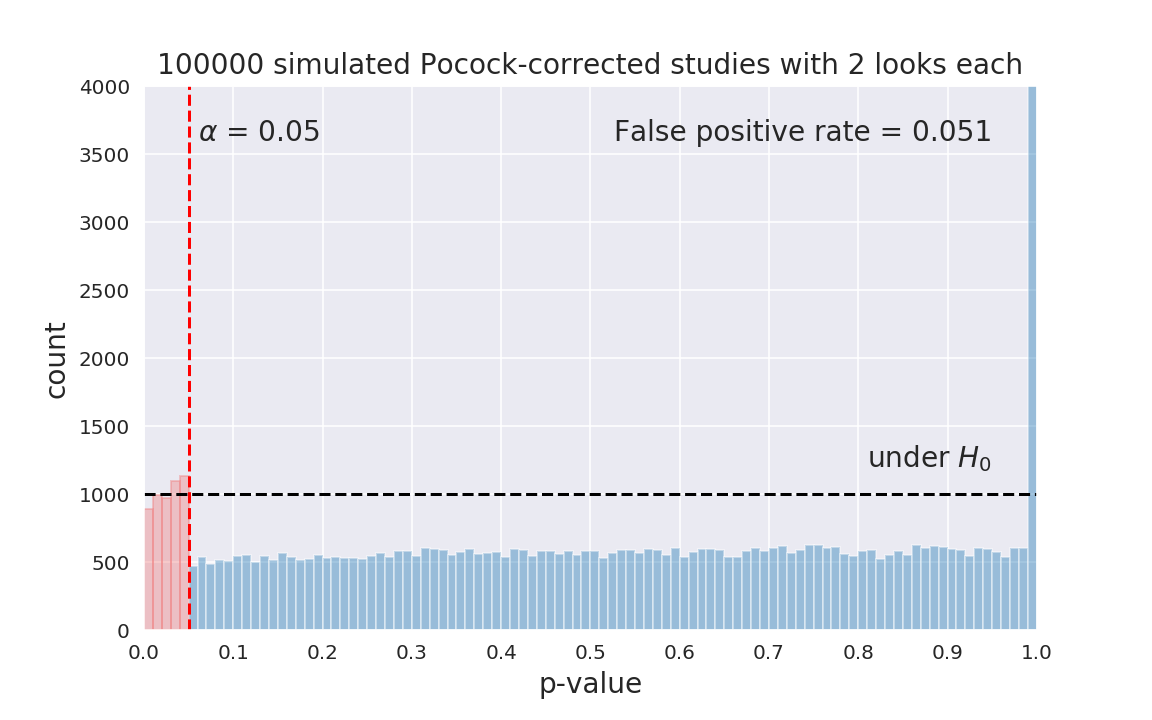

In [12]:
plot_pvalues_optional_stopping_pocock()

Since the Pocock method has the same $\alpha_i$ for each interim test, this means that it spends relatively much $\alpha$ at the  earlier looks. It allows for  a relatively loose significance level at the early stages of data collection and hence, is more likely to allow for early termination of data collection. However, at later stages when more data is collected and real effects should be easier to detect, the significance level is relatively strict so that it is harder to conclude significance in the final stage. An example: if a final test yields a p-value of 0.02, it would have been significant if no  sequential analysis was performed, but in the  case of a Pocock corrected study with 5 interim tests, the significance level for the final test is final 0.0158 so that the overall study has to be seen as insignificant. 

This goes a bit against the intuition that with more data, it should be easier to obtain significant results if there is a true effect. The [O'Brien-Fleming boundary](https://www.jstor.org/stable/2530245?seq=1#page_scan_tab_contents) (OBF) addresses this issue by spending less $\alpha$ at the earlier interim tests and more towards the end. Of course, that makes it much more difficult to stop at an earlier stage. For five interim tests, the OBF-corrected $\alpha_i$ are $\alpha_1$=0.000005, $\alpha_2$=0.0013, $\alpha_3$=0.0085, $\alpha_4$=0.0228, and $\alpha_5$=0.0417. You can see in the figure below how the OBF correction manages to control the false positive rate as well.

Column
    [0] Column(align='center')
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='nlook', options=[2, 4, 5], value=2)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00233')
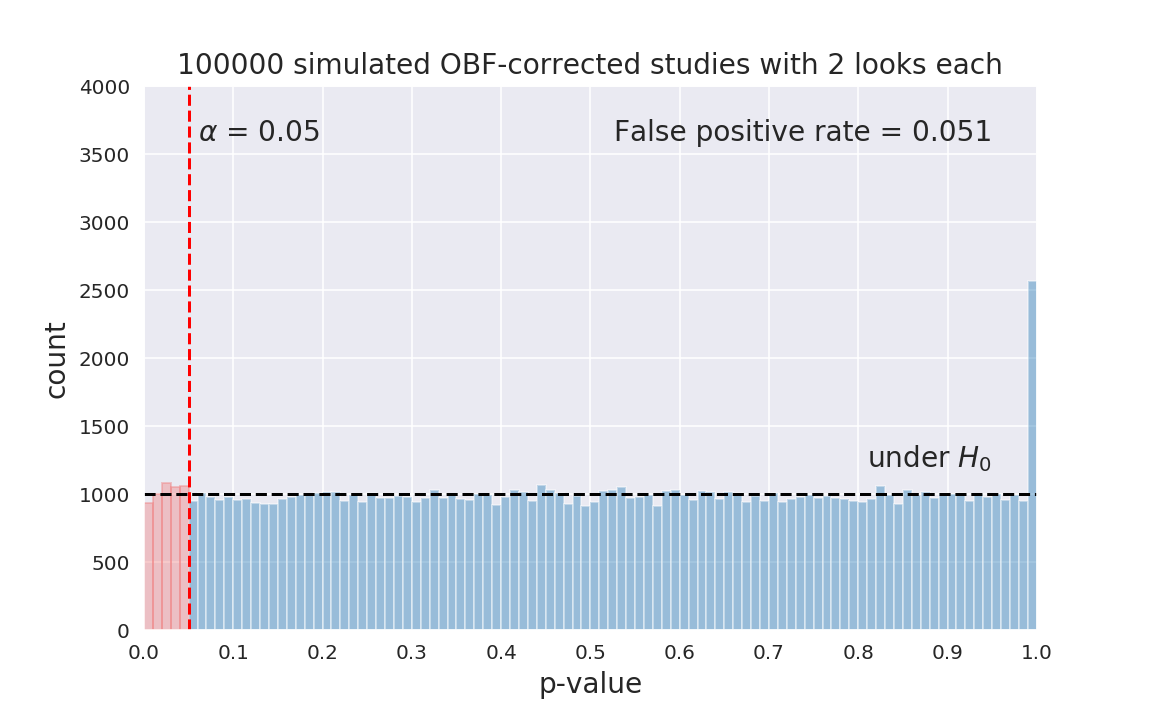

In [13]:
plot_pvalues_optional_stopping_obf()

### Alpha spending function <a id="stop4" ></a>
When we run simulations as above, we can just chose how many interim tests we want to do and in many properly planned experiments, this can be scheduled in advance as well. But there may be situations in which it is not clear in advance how many looks should be performed. Maybe data collection will be easier or cheaper at the beginning or the end of the collection process. Maybe it also makes sense to not have an equal spacing of data  points between the looks. The boundary methods discussed above do not provide this flexibility.

[DeMets and Lan](https://eclass.uoa.gr/modules/document/file.php/MATH301/PracticalSession3/LanDeMets.pdf) have developed the alpha spending fucntion approach to address this inflexibility. They proposed continuous approximation of the Pocock or OBF boundaries (there are also linear and power-family functions) to calculate how much $\alpha$ is spent if one performs an interim test. I don't want to go in too much more detail here, as I assume the results of simulations with this correction would not look much different from what I've already simulated above. If, however, you are in a situation where you'd like to calculate your alpha spending flexibly, there is a [package in R](https://github.com/rpahl/GroupSeq) called `GroupSeq` for this purpose.

A final remark about optional stopping: If a study is stopped early, obviously that means the sample size is smaller. Maybe a statistically significant result was found, but the quality of the effect size estimate will be lower. I don't want to discuss effect sizes (I discuss them in [another project](https://github.com/Pascal-Bliem/european-social-survey) of mine) and confidence intervals here because that would inflate the scope of this project too much. Be aware, however, that effect sizes are usually biased upwards for small samples and that the confidence intervals around the effect size estimates are much larger for smaller samples, which means there is more uncertainty associated with the estimate.

## Power increase and error comparison <a id="power"></a>

### Attempts to avoid false negatives <a id="power1"></a>
I have actually been discussing false negatives already a lot in all the previous section when talking about power. Remember, power is 1-$\beta$, where $\beta$ is the false negative rate (also called type 2 error). False negative error control is generally a bit trickier because the power always depends on the actual effect size which is usually not known in advance. We can try to define the power for the smallest effect size we care about and define the sample size we need to achieve it at the given significance level, $\alpha$, and just go with that. But the actual power will still depend on the size of the actual effect. It is hard to quantify exactly what your false negative rate will be, but there a a few things that can be done to lower it. 

The first and best thing to do is always increase the sample size. The higher the sample size the higher the power, the less biased and more accurate the effect size estimate. Another strategy is trying to keep the measurement error as low as possible to decrease the variability in the data. As displayed in the interactive plot above showing $H_0$ and $H_a$, the less the two distributions overlap, the higher the power will be. Some examples: if you measure some natural phenomenon, perform several measurements per subject; if you survey people, base their score on several questions with wide enough response options; if you track the users on your website, maybe use a success metric that is based on several user actions. When testing different conditions on people, one can greatly reduce variability by using a within-subject design instead of a between-subject design (testing different conditions on the same group, before and after, instead of on different groups). If one already has a directional hypothesis (e.g. increase in quantity of interest), one can perform one-sided instead of two-sided tests. In a one-sided test, the critical value corresponding to the same $\alpha$ will be further away from $H_a$ and, hence, the power will be higher.


    
### False negatives and false positives in comparison <a id="power2"></a>
Which errors are worse? False positives (type 1) or false negatives (type 2)? Again, it  depends. What is the cost of making an error? If we think about the academic scientific process, false positives will be uncovered if replication studies are performed. Unfortunately, that does not happen as much as it should. False negatives could be considered worse though, because they could kill the interest of anyone doing further research in that direction. 

How is it in other fields? In medicine, there are many situations where we would rather want to detect all actual positives at the cost of having some extra false positives. Imagine you perform some quick test to check for a dangerous illness - you'd rather trigger a false alarm that leads to more rigorous but unnecessary follow-up investigations than missing the illness which results in the patient's death. In many business contexts it may be the other way around. If you don't implement an actually cool new feature on your website because it didn't pass the significance test (false negative), your customer won't know and won't care. But if you think some new feature is gonna be great but the customers actually hate it (false positive), you'll lose a lot of money. Think of recommendation systems: If you fail to show some of the interesting products, no one will notice; but if you show a lot of things people are not interested in, they won't be as engaged with your site.

As always, it depends. That is not an overly satisfying answer, I know. In practice, one will have to find a satisfactory trade-off between what is desirable and what is feasible. From a psychological point of view (don't quote me, I'm not a psychologist), I think humans are more prone to make false positive errors because we want to find interesting results. There are countless example in the scientific literature that show that people pull a lot of stunts, being very flexible in their data analysis, introduce new covariates, sometimes even perform p-hacking, to torture the p-value below 0.05. I want to point, again, to the paper I already mentioned in the introduction, [*Why most published research is wrong*](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0020124). I see no reason why this should behave differently in experimentation in a business/industry context, it just doesn't usually become public. Hence, I think rigorous false positive control is very important and that's why I devoted most of this whole discussion here to this topic.

 
### Confirmatory analysis and pre-registration  <a id="power3"></a> 
  
Another phenomenon that can inflate false positive rates is an insufficient separation of **exploratory and confirmatory analysis**. This often leads to hypothesizing after exploring the data. People see something in the data that looks interesting, build a hypothesis on it, and then turn the story around and make it look like that was the hypothesis they had in the first place and their data now confirms it. Often, such apparently significant insights from exploration will fail to replicate in a confirmation study. Just don't use the same data for exploration and then confirmation of your exploratory findings, it doesn't make sense.

I think this idea is comparable to a common problem in machine learning: overfitting to the training data and then being surprised that the model generalizes poorly to new data. That's why we keep a hold-out data set in machine learning problems. We split it off the training data before we even start exploratory data analysis to make sure we can test the model's generalization performance on data which neither us humans nor the algorithm have seen before. I think the same idea applies to statistical testing. If we build and test hypotheses on the same data, it may be like overfitting on training data. Of course data exploration is necessary, but we should come up with a well defined hypothesis and test design in the exploratory phase and then take unused data to conduct confirmatory analysis and tests. This way, we can be (a little more) sure that we don't fool ourselves.

If you want to confirm a theory or hypothesis without fooling yourself (too much), a great idea is to **pre-register** your methodology (e.g. with a scientific journal if you work in academia or with the experimentation team at your company). Pre-registering the test design after exploration and then actually sticking with it during confirmation may seem a little bit inflexible, but it formalizes your false positive rate. And hey, that's what this whole work here is about, right - **error control**.

## Conclusion <a id="conclusion"></a> 
In this project I discussed some essential aspects of error control in statistical testing. After an [introduction](#testing) to the topic, I explained the meaning of [p-values and significance levels](#pvalue), as well as the different [types of errors](#error) and power in null hypothesis significance testing. Further, I discussed how false positive error rates can be inflated in situations where [multiple tests](#multiple) or sequential analysis with [optional stopping](#stop) are performed, and how one can apply different correction methods to control the false positive rate in these situations. Finally, I highlighted a few strategies for reducing the false negative error rate, compared the impact of both false positives and false negatives in different situations, and argued for a separation of exploratory and confirmatory analysis.

That was a lot of information. This whole project got a lot longer and more detailed than I anticipated and I learned a lot through researching the many error control methods. If you made it all the way down here, I hope you learned something as well and found it as exciting as I did. Thanks a lot for your interest and following along. If you are generally interested in the application of statistical models on real data, you may like my project on the [European Social Survey](https://github.com/Pascal-Bliem/european-social-survey), in which I go through data selection and cleaning, interactive exploration, statistical testing, and survey answer prediction with different machine learning models. 

I wish you happy testing with low error rates!